Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
# Load libraries
import pandas as pd
import numpy as np
from numpy import *
import re
from time import time

# Load matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn for visualization
import seaborn as sns
sns.set_style("darkgrid")

# Load sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as ss
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

# Load other ml models 
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, LGBMClassifier, Booster
from xgboost import XGBRegressor

#Remove warnings
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

print('Project libraries has been successfully been imported!')

Project libraries has been successfully been imported!


In [2]:
# read the data
try:
    rb = pd.read_csv('/datasets/car_data.csv')
    
except:
    rb = pd.read_csv('car_data.csv')   
    
print('Data has been read correctly!')

Data has been read correctly!


In [3]:
# Checking 0's
def zero_check(df):
    for i in df:
        print(i,len(df[df[i]==0]))
        
# function to determine if columns in file have null values        
def get_percent_of_na(df, num):
    count = 0
    df = df.copy()
    s = (df.isna().sum() / df.shape[0])
    for column, percent in zip(s.index, s.values):
        num_of_nulls = df[column].isna().sum()
        if num_of_nulls == 0:
            continue
        else:
            count += 1
        print('{} has {} nulls, which is {:.{}%} percent of Nulls'.format(column, num_of_nulls, percent, num))
    if count != 0:
        print("\033[1m" + 'There are {} columns with NA.'.format(count) + "\033[0m")
    else:
        print()
        print("\033[1m" + 'There are no columns with NA.' + "\033[0m")       
        
# function to display general information about the dataset
def general_info(df):
    print("\033[1m" + "\033[0m")
    display(pd.concat([df.dtypes, df.count(),df.isna().sum(),df.isna().sum()/len(df)], keys=['type','count','na','na%'],
                      axis=1))
    print()
    print("\033[1m" + 'Head:')  
    display(df.head())
    print()
    print("\033[1m" + 'Tail:')
    display(df.tail())
    print()
    print("\033[1m" + 'Info:')
    print()
    display(df.info())
    print()
    print("\033[1m" + 'Describe:')
    print()
    display(df.describe())
    print()
    print("\033[1m" + 'Describe include: all :')
    print()
    display(df.describe(include='all'))
    print()
    print("\033[1m" + 'nulls in the columns:')
    print()
    display(get_percent_of_na(df, 4))  # check this out
    print()
    print("\033[1m" + 'Zeros in the columns:') 
    print()
    display(zero_check(df))
    print()
    print("\033[1m" + 'Shape:', df.shape)
    print()
    print()
    print('Duplicated:',"\033[1m" + 'We have {} duplicated rows\n'.format(df.duplicated().sum()) + "\033[0m")
    print()
    print("\033[1m" + 'Dtypes:')  
    display(df.dtypes)
    print()
    print("\033[1m" + 'correlation:')  
    display(df.corr())
    print()

In [4]:
#print our info data
print('information about Our "car_data" dataset:')
general_info(rb)
print()

information about Our "car_data" dataset:



,type,count,na,na%
DateCrawled,object,354369,0,0.000000
Price,int64,354369,0,0.000000
VehicleType,object,316879,37490,0.105794
RegistrationYear,int64,354369,0,0.000000
Gearbox,object,334536,19833,0.055967
Power,int64,354369,0,0.000000
Model,object,334664,19705,0.055606
Mileage,int64,354369,0,0.000000
RegistrationMonth,int64,354369,0,0.000000
FuelType,object,321474,32895,0.092827



Head:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17



Tail:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15
354368,20/03/2016 19:41,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,20/03/2016 00:00,0,40764,24/03/2016 12:45



Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7),

None


Describe:



,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Describe include: all :



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,15470,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,18592
top,05/03/2016 14:25,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,03/04/2016 00:00,NaN,NaN,07/04/2016 07:16
freq,66,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,654
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN



nulls in the columns:

VehicleType has 37490 nulls, which is 10.5794% percent of Nulls
Gearbox has 19833 nulls, which is 5.5967% percent of Nulls
Model has 19705 nulls, which is 5.5606% percent of Nulls
FuelType has 32895 nulls, which is 9.2827% percent of Nulls
NotRepaired has 71154 nulls, which is 20.0791% percent of Nulls
There are 5 columns with NA.


None


Zeros in the columns:

DateCrawled 0
Price 10772
VehicleType 0
RegistrationYear 0
Gearbox 0
Power 40225
Model 0
Mileage 0
RegistrationMonth 37352
FuelType 0
Brand 0
NotRepaired 0
DateCreated 0
NumberOfPictures 354369
PostalCode 0
LastSeen 0


None


Shape: (354369, 16)


Duplicated: We have 262 duplicated rows


Dtypes:


DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Mileage               int64
RegistrationMonth     int64
FuelType             object
Brand                object
NotRepaired          object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object


correlation:


,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Mileage,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


<hr><h2>Data description</h2>

<b style="font-size: 14px;">Number of `rows`:35k</b>

<b style="font-size: 14px;">Number of `cols`:16</b>

<br>

**Features**

- `DateCrawled` - date profile was downloaded from the database


- `VehicleType` - vehicle body type


- `RegistrationYear` - vehicle registration year


- `Gearbox` - gearbox type


- `Power` - power (horse power)


- `Model` - vehicle model


- `Mileage` - mileage (Total miles covered by this vehicle since new)


- `RegistrationMonth` - vehicle registration month


- `FuelType` - fuel type


- `Brand` - vehicle brand


- `NotRepaired` - vehicle repaired or not


- `DateCreated` - date of profile creation


- `NumberOfPictures` - number of vehicle pictures


- `PostalCode` - postal code of profile owner (user)


- `LastSeen` - date of the last activity of the user

<br>

**Target**

`Price` - price (Euro)

<br>

**Missing values**

yes in 5 columns: `VehicleType`, `gearbox`, `Model`, `fuel_type`, `NotRepaired`

<br>

**Duplicates**

yes 262 rows 

<br>

**Dtype issue**

it's recommend that we going to change our columns : `date_crawled`,`date_created`,`last_seen` to datetime

<br>
<b><u>What we notice in our data:</u></b>

- That the values of `Power` column is mix of values that can be split into 3 : 
  - (1) real horse power 50 - 600 hp (we choice this as borderline)
  - (2) lower or values that can't be correct under 50hp 
  - (3) values that our engine size AKA 'cc', like skoda octavia that show in power column 1600 as value 
<br> <br> 
- Our data `postal code` does not have the ability to present a significant figure that would show an advantage of the locations of one vehicle over another This is due to the fact that it is a European data that we do not know from which country . if it was from USA we can tell country 'x' is a drier one and then there is no rust, or a vehicle from a country where there is high humidity and the chance of rust, we remove it before we train our model.
<br><br>
- `NumberOfPictures`, this could impact the price but since all the rows in this column is '0' , so no impact and we can say this column not bring noting this way we remove it in before we start to train our model.
<br><br>
- 5 columns with missing values: `VehicleType`, `gearbox`, `Model`, `fuel_type`, `NotRepaired`
<br><br>
- 262 rows of duplicates that will be remove
<br><br>
- change the date columns `date_crawled`,`date_created`,`last_seen` into datetime format
<br><br>
- In `FuelType` , found the same type of fuel in different pronunciation petrol and gasoline


- `RegistrationYear` as min value of 1000 and max is 9999 , after we check it we found that everything above 2019 is incorrect data for year value

<hr><h2>Data preprocessing</h2>

<h3>Rename columns:</h3>

In [5]:
#Renaming columns
rb.columns = ['date_crawled','price','type','reg_year', 'transmission','power','model','mileage','reg_month','fuel','brand',
              'not_repaired','date_created','num_of_pictures','zip','last_seen']
rb.columns

Index(['date_crawled', 'price', 'type', 'reg_year', 'transmission', 'power',
       'model', 'mileage', 'reg_month', 'fuel', 'brand', 'not_repaired',
       'date_created', 'num_of_pictures', 'zip', 'last_seen'],
      dtype='object')

We short our column values and lowercase it

<hr><h3>Dtype change:</h3>

Convert our date columns to datetime type

In [6]:
#Changing date columns data types
rb['date_crawled'] = pd.to_datetime(rb['date_crawled'], format='%d/%m/%Y %H:%M')
rb['date_created'] = pd.to_datetime(rb['date_created'], format='%d/%m/%Y %H:%M')
rb['last_seen'] = pd.to_datetime(rb['last_seen'], format='%d/%m/%Y %H:%M')

print()
print('date_crawled:')
print(rb['date_crawled'].value_counts(dropna=False))
print()
print('date_created:')
print(rb['date_created'].value_counts(dropna=False))
print()
print('last_seen:')
print(rb['last_seen'].value_counts(dropna=False))


date_crawled:
2016-03-05 14:25:00    66
2016-03-05 14:26:00    59
2016-03-16 18:49:00    55
2016-03-05 17:49:00    54
2016-03-05 15:48:00    54
                       ..
2016-03-11 01:53:00     1
2016-04-04 17:26:00     1
2016-04-02 12:11:00     1
2016-03-31 21:23:00     1
2016-04-05 00:47:00     1
Name: date_crawled, Length: 15470, dtype: int64

date_created:
2016-04-03    13719
2016-04-04    13317
2016-03-20    12918
2016-03-12    12840
2016-03-21    12691
              ...  
2015-11-10        1
2016-01-06        1
2015-03-20        1
2015-06-18        1
2015-11-12        1
Name: date_created, Length: 109, dtype: int64

last_seen:
2016-04-07 07:16:00    654
2016-04-07 06:45:00    646
2016-04-06 09:17:00    641
2016-04-06 04:45:00    640
2016-04-07 05:45:00    640
                      ... 
2016-03-15 07:29:00      1
2016-03-14 07:06:00      1
2016-03-07 18:50:00      1
2016-03-28 11:13:00      1
2016-03-29 01:42:00      1
Name: last_seen, Length: 18592, dtype: int64


<hr><h3>Duplicates:</h3>

Since we have small number of duplicates rows (262) it's better to remove than try to fix them in this dataset

In [7]:
rb.duplicated().sum()

262

In [8]:
rb = rb.drop_duplicates(keep=False)
rb.duplicated().sum()

0

<hr><h3 style="font-size: 100%">Missing values:</h3>

In [9]:
rb.isnull().sum()/rb.shape[0]

date_crawled       0.000000
price              0.000000
type               0.105916
reg_year           0.000000
transmission       0.056033
power              0.000000
model              0.055666
mileage            0.000000
reg_month          0.000000
fuel               0.092931
brand              0.000000
not_repaired       0.201037
date_created       0.000000
num_of_pictures    0.000000
zip                0.000000
last_seen          0.000000
dtype: float64

<hr><h3 style="font-size: 100%"> Process`not_repaired`column:</h3>

In [10]:
#before we fillna our NaN's
rb['not_repaired'].value_counts(dropna=False)

no     246693
NaN     71136
yes     36016
Name: not_repaired, dtype: int64

In [11]:
#after we fillna our NaN's
rb['not_repaired'].fillna('no', inplace=True)
rb['not_repaired'].value_counts(dropna=False)

no     317829
yes     36016
Name: not_repaired, dtype: int64

Since the most common in our column is 'no' we going to change the missing values with this

<hr><h3 style="font-size: 100%"> Process`model`column:</h3>

In [12]:
#fillna our NaN's' with 'other' value
rb['model'].fillna('other', inplace=True)
rb['model'].value_counts(dropna=False)

other                 44080
golf                  29198
3er                   19727
polo                  13048
corsa                 12548
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

<hr><h3 style="font-size: 100%"> Process`type`column:</h3>

In [13]:
#fillna our NaN's' with 'other' value
rb['type'].fillna('other', inplace=True)
rb['type'].value_counts(dropna=False)

sedan          91341
small          79675
wagon          65064
other          40762
bus            28729
convertible    20157
coupe          16131
suv            11986
Name: type, dtype: int64

Since we already have the value other we choice it as the fillna of our NaN's values

<hr><h3 style="font-size: 100%"> Process`fuel`column:</h3>

In [14]:
#fillna our NaN's' with 'gasoline' value also merge petrol and gasoline into 'gasoline' and lpg & cng into 'natural gas'
rb['fuel'].replace(['petrol','other','lpg','cng'],['gasoline','gasoline','natural gas','natural gas'],inplace=True)
rb.fuel = rb.fuel.replace(np.nan,'gasoline')
rb['fuel'].value_counts(dropna=False)

gasoline       347653
natural gas      5869
hybrid            233
electric           90
Name: fuel, dtype: int64

Since most of our data vehicles is gasoline we change our NaN's into them also we merge petrol and gasoline since it's the same type in different word and we also merge lpg & cng into new value natural gas

<hr><h3 style="font-size: 100%"> Process`transmission`column:</h3>

In [15]:
#before we fillna our NaN's
rb['transmission'].value_counts(dropna=False)

manual    267817
auto       66201
NaN        19827
Name: transmission, dtype: int64

In [16]:
#replace our NaN's with most common value 'manual'
rb.transmission = rb.transmission.replace(np.nan,'manual')

In [17]:
#after we fillna our NaN's
rb['transmission'].value_counts(dropna=False)

manual    287644
auto       66201
Name: transmission, dtype: int64

We have more manual vehicles than automatic so we change our NaN's into this one

<hr><h2>EDA:</h2>

<h3>`reg_year`column:</h3>

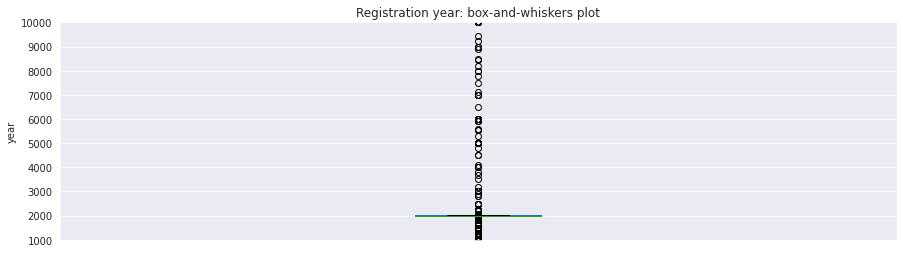

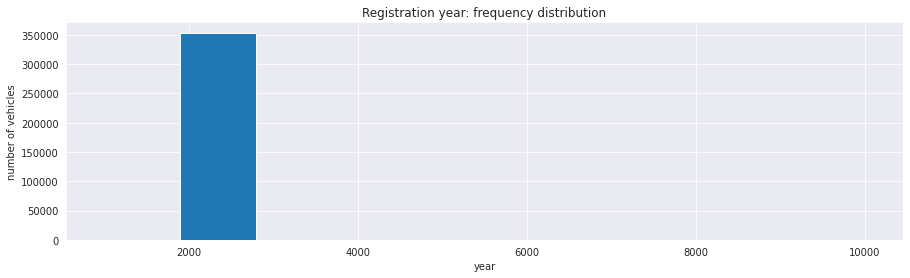

In [18]:
#lets see our Outliers in reg_year column
rb.boxplot('reg_year' ,figsize=(15, 4))
plt.ylim(1000, 10000)
plt.title('Registration year: box-and-whiskers plot')
plt.xticks([1], [''])
plt.ylabel('year');

rb.hist('reg_year' ,figsize=(15, 4))
plt.title('Registration year: frequency distribution')
plt.xlabel('year')
plt.ylabel('number of vehicles');

As we can see our data have a lot of outliers , but the most observations around the year 2000 , And since the real highest registration year in our data is 2019, we going to limit our border between 1900 - 2019

In [19]:
#borderline between 1900 - 2019
rb.loc[(rb['reg_year'] < 1900) | (rb['reg_year'] > 2019), 'reg_year'] = np.nan

In [20]:
#limit values lower than 1900 and higher than 2019 
rb = rb.dropna(subset=['reg_year'], axis=0)
rb.reset_index(drop=True, inplace=True)

<hr><h3>`price`column:</h3>

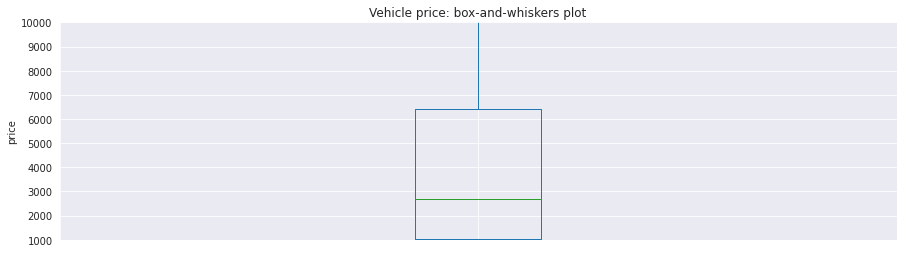

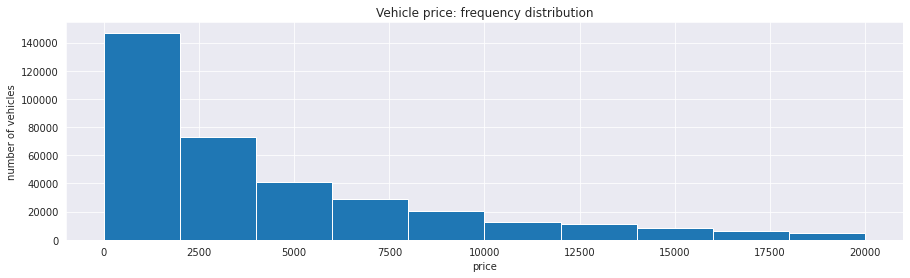

In [21]:
#lets see our Outliers in price column
rb.boxplot('price' ,figsize=(15, 4))
plt.ylim(1000, 10000)
plt.title('Vehicle price: box-and-whiskers plot')
plt.xticks([1], [''])
plt.ylabel('price');

rb.hist('price' ,figsize=(15, 4))
plt.title('Vehicle price: frequency distribution')
plt.xlabel('price')
plt.ylabel('number of vehicles');

As we can see our price range is between 1k to 6k euro, when our max price is 20k which look reasonable price overall. let's see if there is other artifacts

In [22]:
#lets see our len in price column equal to 12345
len(rb[rb['price'] == 12345])

7

In [23]:
#lets see our len in price equal to 1
len(rb[rb['price'] == 1])

1179

In [24]:
#lets see our len in price column equal to 0
len(rb[rb['price'] == 0])

10736

Let's remove then, since this our target column and any value like the one above isn't informative us for any purpose

In [25]:
rb.loc[(rb['price'] == 12345) | (rb['price'] == 1) | (rb['price'] == 0), 'price'] = np.nan

In [26]:
#drop and reset the data
rb = rb.dropna(subset=['price'], axis=0)
rb.reset_index(drop=True, inplace=True)
rb.shape

(341752, 16)

<hr><h3>`mileage`column:</h3>

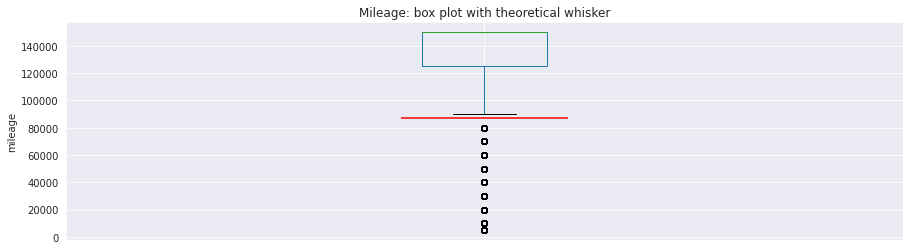

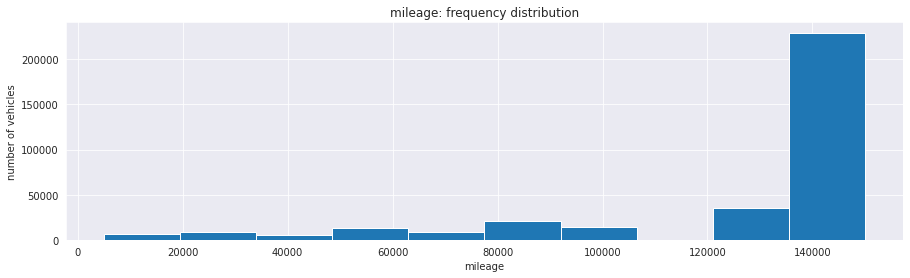

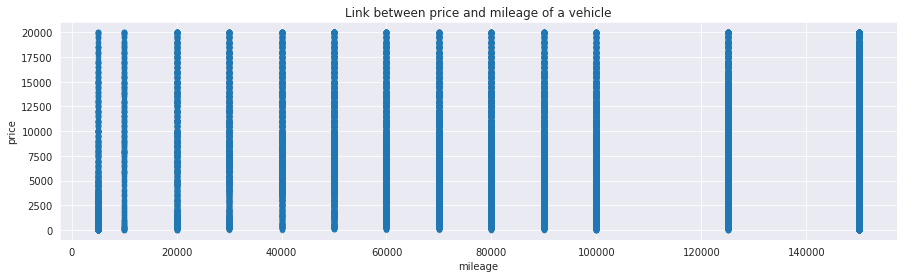

In [27]:
#lets see our Outliers in 'price' column
Q1 = rb['mileage'].quantile(0.25)
Q3 = rb['mileage'].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
rb.boxplot('mileage' ,figsize=(15, 4))
plt.hlines(y=lower_whisker, xmin=0.9, xmax=1.1, color='red')
plt.title('Mileage: box plot with theoretical whisker')
plt.xticks([1], [''])
plt.ylabel('mileage');

len(rb[rb['mileage'] < lower_whisker])

rb.hist('mileage' ,figsize=(15, 4))
plt.title('mileage: frequency distribution')
plt.xlabel('mileage')
plt.ylabel('number of vehicles');

rb.plot.scatter(x='mileage', y='price', alpha=.25,figsize=(15, 4))
plt.title('Link between price and mileage of a vehicle');

Our most observations come with high mileage value , there is some values with lower whisker , so we keep them since there isn't so many and there value can be exist.

Also no clear linear connection between price and mileages

<hr><h3>`power`column:</h3>

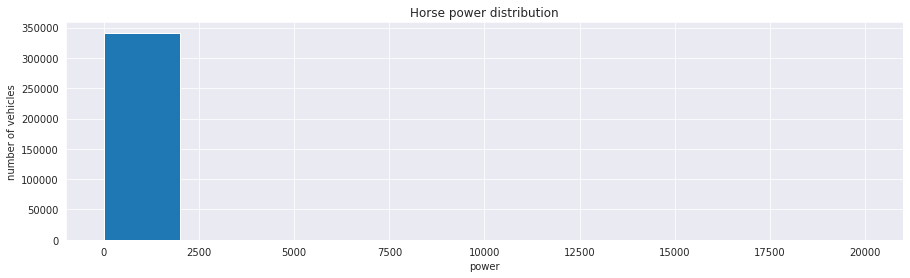

In [28]:
#lets see our Outliers in 'power' column
rb.hist('power' ,figsize=(15, 4))
plt.title('Horse power distribution');
plt.xlabel('power')
plt.ylabel('number of vehicles');

In [29]:
len(rb[rb['power'] > 600])

350

In [30]:
len(rb[rb['power']  < 50])

41447

It's very clear that our 'power' column is combine of values that kind of confusing between 50-600 is power or horsepower lower than 50 incorrect data and higher than 600 is engine size not horse power and to add another column for engine won't solve this issue we going to borderline this column between 50 - 600

In [31]:
#borderline between 50 - 600 hp everything above or lower is outliers
rb.loc[(rb['power'] > 600) | (rb['power'] < 50), 'power'] = np.nan

rb = rb.dropna(subset=['power'], axis=0)
rb.reset_index(drop=True, inplace=True)
rb.shape

(299955, 16)

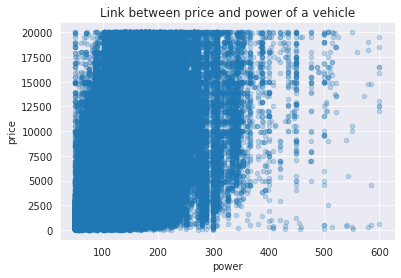

In [32]:
rb.plot.scatter(x='power', y='price', alpha=.25)
plt.title('Link between price and power of a vehicle');

We can't see any clear linear connection between the price and the power

<hr><h3>extra data column vehicle age:</h3>

Let's calc the age of our vehicle when the target is the price

we going to extract the 'year' for our profile creation from the reg_year column 

In [33]:
#new column to see the age of the vehicle in our data
rb['year_created'] = rb['date_created'].dt.year
rb['age'] = rb['year_created'] - rb['reg_year']

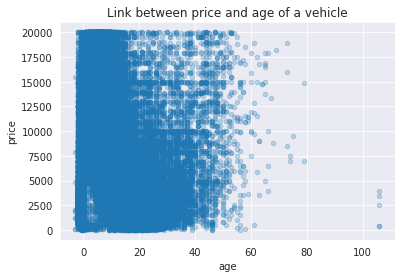

In [34]:
rb.plot.scatter(x='age', y='price', alpha=.25)
plt.title('Link between price and age of a vehicle');

We can see very slight liner negative connection between the price and the age 
lower age , lower price although this doesn't stand for all observations, could be other features.

<hr><h3>zip column:</h3>

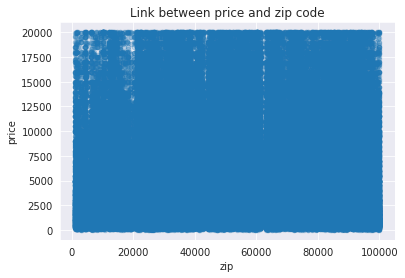

In [35]:
#lets see if there is any link between zip and price
rb.plot.scatter(x='zip', y='price', alpha=.25)
plt.title('Link between price and zip code');

We can't see any liner dependency between this two variables , consider to test a model without zip feature

<hr><h3>Drop columns:</h3>

before we move on let's remove columns that we don't need in our next chapter

In [36]:
#drop columns before encode and train after it
rb=rb.drop(['zip','date_crawled','last_seen','num_of_pictures','reg_month','date_created','reg_year','year_created'],axis=1)

In [37]:
rb.head()

,price,type,transmission,power,model,mileage,fuel,brand,not_repaired,age
0,18300.0,coupe,manual,190.0,other,125000,gasoline,audi,yes,5.0
1,9800.0,suv,auto,163.0,grand,125000,gasoline,jeep,no,12.0
2,1500.0,small,manual,75.0,golf,150000,gasoline,volkswagen,no,15.0
3,3600.0,small,manual,69.0,fabia,90000,gasoline,skoda,no,8.0
4,650.0,sedan,manual,102.0,3er,150000,gasoline,bmw,yes,21.0


<hr><h3>Encoding of categorical variables:</h3>

In [38]:
#encode data
rbnew = OrdinalEncoder()

In [39]:
cat_columns = ['type', 'transmission', 'model', 'fuel', 'brand', 'not_repaired']

In [40]:
rb[cat_columns] = rbnew.fit_transform(rb[cat_columns])

In [41]:
rb.head()

,price,type,transmission,power,model,mileage,fuel,brand,not_repaired,age
0,18300.0,2.0,1.0,190.0,166.0,125000,1.0,1.0,1.0,5.0
1,9800.0,6.0,0.0,163.0,117.0,125000,1.0,14.0,0.0,12.0
2,1500.0,5.0,1.0,75.0,116.0,150000,1.0,38.0,0.0,15.0
3,3600.0,5.0,1.0,69.0,101.0,90000,1.0,31.0,0.0,8.0
4,650.0,4.0,1.0,102.0,11.0,150000,1.0,2.0,1.0,21.0


<hr><h2>Model training & analysis</h2>

Splitting data into train, validation and test sets

let's split data into train and test sets with the 80/20 proportion, respectively

In [42]:
#split our data intro train and test set
X = rb.drop(['price'], axis=1)
y = rb['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12345)

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,test_size = 0.2, random_state=12345)

In [44]:
X_train.describe()

,type,transmission,power,model,mileage,fuel,brand,not_repaired,age
count,191971.000000,191971.000000,191971.000000,191971.000000,191971.000000,191971.000000,191971.000000,191971.000000,191971.000000
mean,4.179439,0.801829,121.858400,109.870173,128673.523605,1.035979,20.626631,0.095556,12.546557
std,2.074913,0.398622,53.329586,70.328782,36475.302564,0.265269,13.406652,0.293982,6.724550
min,0.000000,0.000000,50.000000,0.000000,5000.000000,0.000000,0.000000,0.000000,-3.000000
25%,3.000000,1.000000,80.000000,42.000000,125000.000000,1.000000,9.000000,0.000000,8.000000
50%,4.000000,1.000000,114.000000,116.000000,150000.000000,1.000000,23.000000,0.000000,13.000000
75%,5.000000,1.000000,150.000000,166.000000,150000.000000,1.000000,33.000000,0.000000,17.000000
max,7.000000,1.000000,600.000000,248.000000,150000.000000,3.000000,39.000000,1.000000,106.000000


<hr><h3>Standard scaling</h3>

Scale the features before modeling to be able to compare their coefficients in the later sections

In [45]:
#scaling our split data
sc = ss()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)
X_test =  sc.transform(X_test)

<hr><h3>Model selection</h3>

We will be using the RMSE metric for best model selection

<h3>Linear regression:</h3>

In [46]:
LR = LinearRegression()
start = time()
LR.fit(X_train, y_train)
end = time()
fit_time_LR = end - start

start = time()
y_pred = LR.predict(X_valid)
end = time()
predict_time_LR = end - start

LR_score = mean_squared_error(y_valid, y_pred) ** 0.5
LR_score

3077.1481854447297

<h3>Random Forest(Base Model):</h3>

In [47]:
RF = RandomForestRegressor()

start = time()
RF.fit(X_train, y_train)
end = time()
fit_time_RF = end - start

start = time()
y_pred = RF.predict(X_valid)
end = time()
predict_time_RF = end - start

RF_score_base = mean_squared_error(y_valid, y_pred) ** 0.5
RF_score_base

1633.3817331423525

<h3>Random Forest(Hyperparameters tuning):</h3>

In [48]:
d = []
for estim in [100, 500]:
    for depth in [5,10]:
        RF = RandomForestRegressor(random_state=12345, n_estimators=estim, max_depth=depth)
        
        start = time()
        RF.fit(X_train, y_train)
        end = time()
        fit_time_RF_tuned = end - start
        
        start = time()
        y_pred = RF.predict(X_valid)
        end = time()
        predict_time_RF_tuned = end - start
        
        RF_score_tuned = mean_squared_error(y_valid, y_pred) ** 0.5
        d.append(
            {
                'n_estimators': estim,
                'max_depth': depth,
                'RF_score_tuned':  RF_score_tuned,
                'fit_time_RF_tuned': fit_time_RF_tuned,
                'predict_time_RF_tuned': predict_time_RF_tuned
            }
        )
best_param = pd.DataFrame(d).nsmallest(1, ['RF_score_tuned'], keep='first')
RF_score_tuned = best_param['RF_score_tuned'].values
fit_time_RF_tuned = best_param['fit_time_RF_tuned'].values
predict_time_RF_tuned = best_param['predict_time_RF_tuned'].values

best_param

,n_estimators,max_depth,RF_score_tuned,fit_time_RF_tuned,predict_time_RF_tuned
3,500,10,1922.633916,128.437068,2.341153


<h3>XGBoost(base model):</h3>

In [49]:
XGB = XGBRegressor(n_jobs=-1)

start = time()
XGB.fit(X_train, y_train)
end = time()
fit_time_XGB = end - start

start = time()
y_pred = XGB.predict(X_valid)
end = time()
predict_time_XGB = end - start

XGB_score_base = mean_squared_error(y_valid, y_pred) ** 0.5
XGB_score_base

1669.4110759282837

<h3>XGBoost(Hyperparameters tuning):</h3>

In [50]:
d = []
for estim in [100, 500]:
    for depth in [5, 10]:
        XGB = XGBRegressor(random_state=12345, n_estimators=estim, 
                                       max_depth=depth, n_jobs=-1)
        start = time()
        XGB.fit(X_train, y_train)
        end = time()
        fit_time_XGB_tuned = end - start
        
        start = time()
        y_pred = XGB.predict(X_valid)
        end = time()
        predict_time_XGB_tuned = end - start
        
        XGB_score_tuned = mean_squared_error(y_valid, y_pred) ** 0.5
        d.append(
                        {
                            'n_estimators': estim,
                            'max_depth': depth,
                            'XGB_score_tuned':  XGB_score_tuned,
                            'fit_time_XGB_tuned': fit_time_XGB_tuned,
                            'predict_time_XGB_tuned': predict_time_XGB_tuned
                        }
                    )

best_param = pd.DataFrame(d).nsmallest(1, ['XGB_score_tuned'], keep='first')
XGB_score_tuned = best_param['XGB_score_tuned'].values
fit_time_XGB_tuned = best_param['fit_time_XGB_tuned'].values
predict_time_XGB_tuned = best_param['predict_time_XGB_tuned'].values

best_param

,n_estimators,max_depth,XGB_score_tuned,fit_time_XGB_tuned,predict_time_XGB_tuned
1,100,10,1586.818972,79.613074,0.286358


<h3>LightGBM(base model):</h3>

In [51]:
LGB = LGBMRegressor()

start = time()
LGB.fit(X_train, y_train)
end = time()
fit_time_LGB = end - start

start = time()
y_pred = LGB.predict(X_valid)
end = time()
predict_time_LGB = end - start

LGB_score_base = mean_squared_error(y_valid, y_pred) ** 0.5
LGB_score_base

1742.6192673665391

<h3>LightGBM(Hyperparameters tuning):</h3>

In [52]:
d = []
for estim in [100, 500]:
    for depth in [5, 10]:
        LGB = LGBMRegressor(random_state=12345, n_estimators=estim, 
                                       max_depth=depth)
        start = time()
        LGB.fit(X_train, y_train)
        end = time()
        fit_time_LGB_tuned = end - start
        
        start = time()
        y_pred = LGB.predict(X_valid)
        end = time()
        predict_time_LGB_tuned = end - start
        
        LGB_score_tuned = mean_squared_error(y_valid, y_pred) ** 0.5
        d.append(
            {
                 'n_estimators': estim,
                  'max_depth': depth,
                  'LGB_score_tuned':  LGB_score_tuned,
                  'fit_time_LGB_tuned': fit_time_LGB_tuned,
                  'predict_time_LGB_tuned': predict_time_LGB_tuned
                        }
                    )

best_param = pd.DataFrame(d).nsmallest(1, ['LGB_score_tuned'], keep='first')
LGB_score_tuned = best_param['LGB_score_tuned'].values
fit_time_LGB_tuned = best_param['fit_time_LGB_tuned'].values
predict_time_LGB_tuned = best_param['predict_time_LGB_tuned'].values

best_param

,n_estimators,max_depth,LGB_score_tuned,fit_time_LGB_tuned,predict_time_LGB_tuned
3,500,10,1627.393517,19.395644,1.688881


<h3>CatBoost(base model):</h3>

In [53]:
CB = CatBoostRegressor(verbose=0)

start = time()
CB.fit(X_train, y_train)
end = time()
fit_time_CB = end - start

start = time()
y_pred = CB.predict(X_valid)
end = time()
predict_time_CB = end - start

CB_score_base = mean_squared_error(y_valid, y_pred) ** 0.5
CB_score_base

1663.1869224894342

<h3>CatBoost(Hyperparameters tuning):</h3>

In [54]:
d = []
for iterations in [100, 500]:
    for depth in [5, 10]:
        CB = CatBoostRegressor(random_state=12345, iterations=iterations, 
                                       depth=depth, verbose=0)
        start = time()
        CB.fit(X_train, y_train)
        end = time()
        fit_time_CB_tuned = end - start
        
        start = time()
        y_pred = CB.predict(X_valid)
        end = time()
        predict_time_CB_tuned = end - start
        
        CB_score_tuned = mean_squared_error(y_valid, y_pred) ** 0.5
        d.append(
            {
                            'n_estimators': estim,
                            'depth': depth,
                            'CB_score_tuned':  CB_score_tuned,
                            'fit_time_CB_tuned': fit_time_CB_tuned,
                            'predict_time_CB_tuned': predict_time_CB_tuned
                        }
                    )

best_param = pd.DataFrame(d).nsmallest(1, ['CB_score_tuned'], keep='first')
CB_score_tuned = best_param['CB_score_tuned'].values
fit_time_CB_tuned = best_param['fit_time_CB_tuned'].values
predict_time_CB_tuned = best_param['predict_time_CB_tuned'].values

best_param

,n_estimators,depth,CB_score_tuned,fit_time_CB_tuned,predict_time_CB_tuned
3,500,10,1596.409006,27.413223,0.09944


<h2>Result:</h2>

In [55]:
#let's compere our models total result
models = pd.DataFrame({
    'Model': ['LR', 'RF_base', 'XGB_base', 'LGB_base', 'CB_base','RF_tuned', 'XGB_tuned', 'LGB_tuned', 'CB_tuned'],
    'Score': [LR_score, RF_score_base, XGB_score_base, LGB_score_base, CB_score_base,
             RF_score_tuned, XGB_score_tuned, LGB_score_tuned, CB_score_tuned],
    'Training_time': [fit_time_LR, fit_time_RF, fit_time_XGB, fit_time_LGB, fit_time_CB, fit_time_RF_tuned,
             fit_time_XGB_tuned, fit_time_LGB_tuned, fit_time_CB_tuned],
    'Prediction_time': [predict_time_LR, predict_time_RF, predict_time_XGB, predict_time_LGB, predict_time_CB, 
                        predict_time_RF_tuned,
             predict_time_XGB_tuned, predict_time_LGB_tuned, predict_time_CB_tuned]})

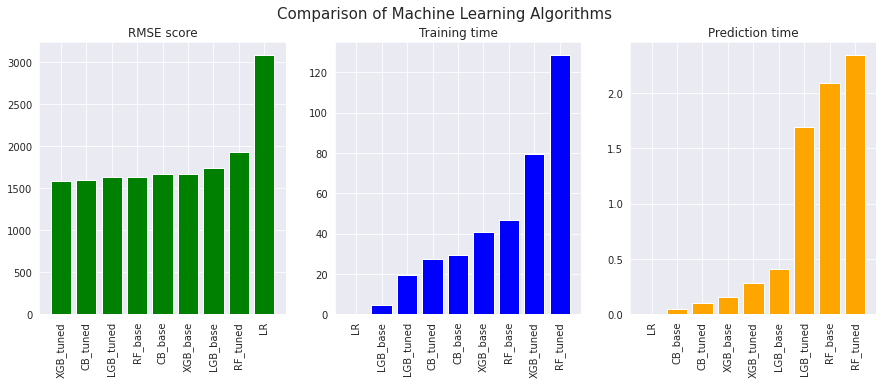

In [56]:
fig, axs = plt.subplots(1,3,figsize=(15,5)) 
fig.suptitle('Comparison of Machine Learning Algorithms', fontsize=15)

labels = models.sort_values(by='Score')['Model']
values = models.sort_values(by='Score')['Score']
axs[0].bar(labels, values, color = 'g')
axs[0].set_xticklabels(labels, rotation='vertical')
axs[0].set_title('RMSE score')

labels = models.sort_values(by='Training_time')['Model']
values = models.sort_values(by='Training_time')['Training_time']
axs[1].bar(labels, values, color = 'b')
axs[1].set_xticklabels(labels, rotation='vertical')
axs[1].set_title('Training time')

labels = models.sort_values(by='Prediction_time')['Model']
values = models.sort_values(by='Prediction_time')['Prediction_time']
axs[2].bar(labels, values, color = 'orange')
axs[2].set_xticklabels(labels, rotation='vertical')
axs[2].set_title('Prediction time');

<hr>
<center>Summary results by different models</center>

|      Model      | n_estimators |  max_depth   |    score     |   fit_time   | predict_time |      tuning       |
|-----------------|--------------|--------------|--------------|--------------|--------------|-------------------|
|Linear regression|              |              |   3077.14    |              |              |    Base Model     |
|Random Forest    |              |              |   1633.38    |              |              |    Base Model     |
|Random Forest    |     500      |       10     |   1922.63    |    128.43    |     2.34     |  Hyper parameters |
|XGBoost          |              |              |   1669.41    |              |              |    Base Model     |
|XGBoost          |     100      |       10     |   1586.81    |     79.61    |     0.28     |  Hyper parameters |
|LightGBM         |              |              |   1742.61    |              |              |    Base Model     |
|LightGBM         |     500      |       10     |   1627.39    |     19.39    |     1.68     |  Hyper parameters |
|CatBoost         |              |              |   1663.18    |              |              |    Base Model     |
|CatBoost         |     500      |       10     |   1596.40    |     27.41    |     0.09     |  Hyperparameters  |


The best score is **XGB_tuned** but is fit time and predict_time isn't the overall best, when we compere it to **CatBoost tuned** that get score little bit less but the fit time and predict_time much faster and since our test was to see the overall model that offer best score and fast time we choice the the **CatBoost tuned** as the final model. 

In [57]:
d = []
for iterations in [100, 500]:
    for depth in [10, 16]:
        for learning_rate in [0.01, 0.05, 0.1]:
            CB = CatBoostRegressor(random_state=12345, iterations=iterations, 
                                           depth=depth, learning_rate=learning_rate, verbose=0)
            start = time()
            CB.fit(X_train, y_train)
            end = time()
            fit_time_CB_tuned = end - start

            start = time()
            y_pred = CB.predict(X_valid)
            end = time()
            predict_time_CB_tuned = end - start

            CB_score_tuned = mean_squared_error(y_valid, y_pred) ** 0.5
            d.append(
                {
                            'n_estimators': estim,
                            'depth': depth,
                            'CB_score_tuned':  CB_score_tuned,
                            'learning_rate': learning_rate,
                            'fit_time_CB_tuned': fit_time_CB_tuned,
                            'predict_time_CB_tuned': predict_time_CB_tuned
                        }
                    )

best_param = pd.DataFrame(d).nsmallest(1, ['CB_score_tuned'], keep='first')
CB_score_tuned = best_param['CB_score_tuned'].values
fit_time_CB_tuned = best_param['fit_time_CB_tuned'].values
predict_time_CB_tuned = best_param['predict_time_CB_tuned'].values
learning_rate = best_param['learning_rate'].values

best_param

,n_estimators,depth,CB_score_tuned,learning_rate,fit_time_CB_tuned,predict_time_CB_tuned
11,500,16,1571.029173,0.1,639.670208,0.328562


Our score improved slightly while the training time has increased several folds. Since the speed is important in this task, let's keep the model with the default learning rate. Finally, we will test our model on the test set.

In [58]:
CB = CatBoostRegressor(random_state=12345, iterations=500,depth=10, verbose=0)
CB.fit(X_train, y_train)
y_pred = CB.predict(X_test)
CB_score_test = mean_squared_error(y_test, y_pred) ** 0.5
CB_score_test

1582.2337836162137

Both validation and test scores are close to each other, we do not observe overfitting

<h2>Retrain the best tuned model:</h2>

In [59]:
X = rb.drop('price', axis=1)
y = rb['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=12345)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [60]:
CB_final = CatBoostRegressor(random_state=12345, iterations=500,depth=10, verbose=0)
start = time()
CB_final.fit(X_train, y_train)
end = time()
fit_time_final = end - start

start = time()
y_pred = CB_final.predict(X_test)
end = time()
predict_time_final = end - start

CB_final_score_test = mean_squared_error(y_test, y_pred) ** 0.5
print('test RMSE score, eur:', round(CB_final_score_test,0))
print('Training time, sec:', round(fit_time_final,0))
print('Prediction time, sec:', round(predict_time_final,2))

test RMSE score, eur: 1571.0
Training time, sec: 32.0
Prediction time, sec: 0.15


Slightly improved due the bigger train set

<hr><h2>Sanity check:</h2>

In [61]:
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
LR_score_test = mean_squared_error(y_test, y_pred) ** 0.5
LR_score_test

3098.4311533568753

In [62]:
round((2698.7226521074763-1523.6258860003888)/2698.7226521074763 * 100, 2)

43.54

Our test score base Linear regression model, is higher than our final model by 43.54%, this means that our modeling choice is useful and better

<hr><div id="general_conclusion"><h2>General conclusion:</h2></div>  

<b><u>INTRODUCTION</u></b>

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

<hr><h2>Data description</h2>

<b style="font-size: 14px;">Number of `rows`:35k</b>

<b style="font-size: 14px;">Number of `cols`:16</b>

<br>

**Features**

- `DateCrawled` - date profile was downloaded from the database


- `VehicleType` - vehicle body type


- `RegistrationYear` - vehicle registration year


- `Gearbox` - gearbox type


- `Power` - power (horse power)


- `Model` - vehicle model


- `Mileage` - mileage (Total miles covered by this vehicle since new)


- `RegistrationMonth` - vehicle registration month


- `FuelType` - fuel type


- `Brand` - vehicle brand


- `NotRepaired` - vehicle repaired or not


- `DateCreated` - date of profile creation


- `NumberOfPictures` - number of vehicle pictures


- `PostalCode` - postal code of profile owner (user)


- `LastSeen` - date of the last activity of the user

<br>

**Target**

`Price` - price (Euro)

<br>

**Missing values**

yes in 5 columns: `VehicleType`, `gearbox`, `Model`, `fuel_type`, `NotRepaired`

<br>

**Duplicates**

yes 262 rows 

<br>

**Dtype issue**

it's recommend that we going to change our columns : `date_crawled`,`date_created`,`last_seen` to datetime

<br>
<b><u>What we notice in our data:</u></b>

- That the values of `Power` column is mix of values that can be split into 3 : 
  - (1) real horse power 50 - 600 hp (we choice this as borderline)
  - (2) lower or values that can't be correct under 50hp 
  - (3) values that our engine size AKA 'cc', like skoda octavia that show in power column 1600 as value 
<br> <br> 
- Our data `postal code` does not have the ability to present a significant figure that would show an advantage of the locations of one vehicle over another This is due to the fact that it is a European data that we do not know from which country . if it was from USA we can tell country 'x' is a drier one and then there is no rust, or a vehicle from a country where there is high humidity and the chance of rust, we remove it before we train our model.
<br><br>
- `NumberOfPictures`, this could impact the price but since all the rows in this column is '0' , so no impact and we can say this column not bring noting this way we remove it in before we start to train our model.
<br><br>
- 5 columns with missing values: `VehicleType`, `gearbox`, `Model`, `fuel_type`, `NotRepaired`
<br><br>
- 262 rows of duplicates that will be remove
<br><br>
- change the date columns `date_crawled`,`date_created`,`last_seen` into datetime format
<br><br>
- In `FuelType` , found the same type of fuel in different pronunciation petrol and gasoline


- `RegistrationYear` as min value of 1000 and max is 9999 , after we check it we found that everything above 2019 is incorrect data for year value

We rename the column titles to short one and we lower case them , fill the missing values and drop values and columns that we didn't need for our next steps.

- **EDA** : We checked for outliers in 5 variables, created a new featured (`age`) and dropped non-informative columns


- **Encoding of categorical variables**: we use ordinal encoding for categorical features when using random forest/decision tree/gradient boosting


- **Splitting data into train, validation and test sets**. Data was split into 3 sets to perform best model selection


- **Standard scaling**


- **Model selection** : We compared Linear Regression, Random Forest, XGBoost, LightGBM and CatBoost models. tuned a few hyperparameters for these algorithms and choose the **CatBoost tuned model** as the based on RMSE score and training and prediction speed


- **Retrain the best tuned model**. Our best model was retrained on the whole training data set in order to increase the volume of data it can learn from. The test score has slightly improved thanks to this step



- **Sanity check**. The test score of the Linear regression model, that we use as a baseline to analyze the model quality, is `43.54%` higher than our final model. It means that the modeling was useful and better

   
The CatBoost model with the tuned hyperparameters has shown the best results (**test RMSE of 1571, time of training 32 seconds, time of prediction 0.15 seconds**) in terms of both quality and speed of training and prediction

<h2>Overall conclusion:</h2>

The goal of this project was to **develop a model to determine the market value of a car based on historical data**. The model had to have a good quality and high offline (training) and online (prediction) speed:

Therefore, we recommend to **Rusty Bargain used car sales service** our choice **CatBoost model tuned** hyperparameters that shown the best results : RMSE of 1571, fit time of 32sec and time of prediction of 0.15 sec in terms of quality and speed this is the best model in our project 

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The models have been trained
- [x]  The analysis of speed and quality of the models has been performed